In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import plotly.express as px
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from bokeh.plotting import figure
import dash
from dash import dcc
from dash import html
# from dash.dependencies import Input, Output
import panel as pn
pn.extension()


In [2]:
# Load the weather data from a CSV file
weather_data = pd.read_csv('C:\\Users\\soura\\OneDrive\\Documents\\CS661_proj\\data\\north_new.csv')


In [3]:
# Convert the 'date' column to datetime format
weather_data['date'] = pd.to_datetime(weather_data['date'])

# weather_data.columns

# Take a sample of 5000 points from weather data
sample_df = weather_data.sample(5000, random_state=101)


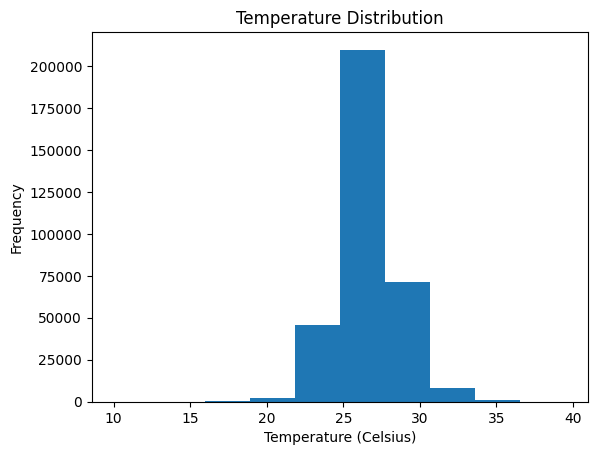

In [4]:
# Visualization : Histogram of temperature
plt.hist(weather_data['temp'])
plt.title('Temperature Distribution')
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Frequency')
plt.show()


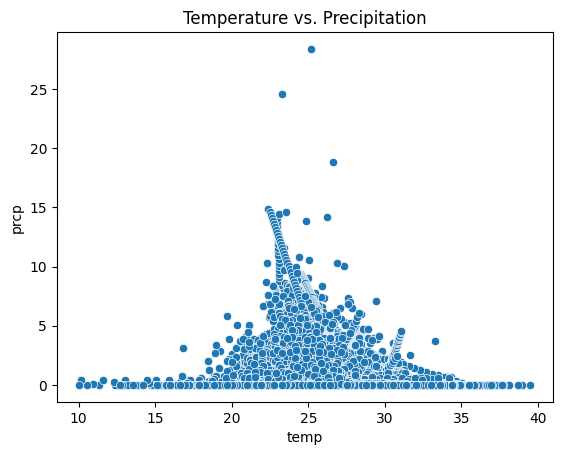

In [5]:
# Visualization : Scatter plot of temperature vs. precipitation
sns.scatterplot(data=weather_data, x='temp', y='prcp')
plt.title('Temperature vs. Precipitation')
plt.show()


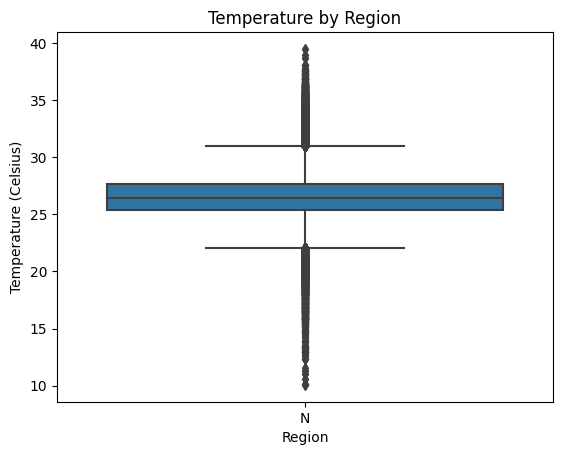

In [6]:
# Visualization: Box plot of temperature by region
sns.boxplot(data=weather_data, x='regi', y='temp')
plt.title('Temperature by Region')
plt.xlabel('Region')
plt.ylabel('Temperature (Celsius)')
plt.show()


In [7]:
# Visualization : Heatmap of correlation between weather variables
corr_matrix = weather_data.copy().corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()


ValueError: could not convert string to float: 'A009'

### Line plot of temperature over time:

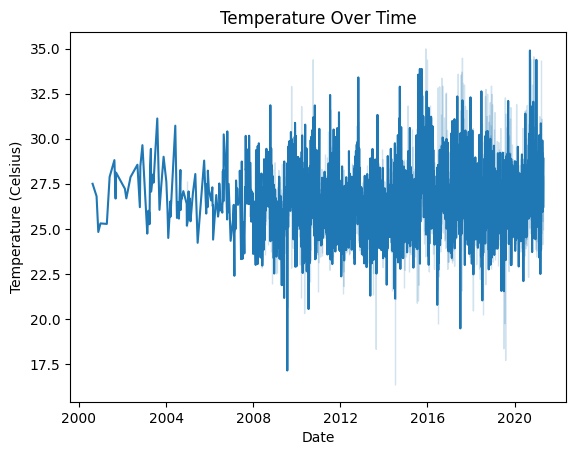

In [8]:
# Line plot of temperature over time
sns.lineplot(data=sample_df, x='date', y='temp')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.show()


### Bar plot of average precipitation by region:

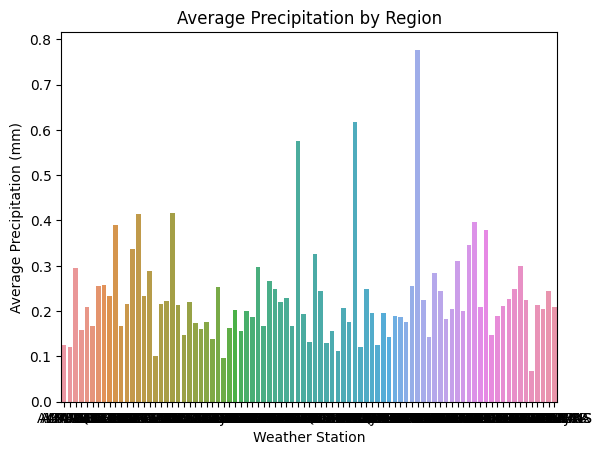

In [9]:
# Group weather data by region and calculate mean precipitation
region_precipitation = weather_data.groupby(
    'wsnm')['prcp'].mean().reset_index()

# Bar plot of average precipitation by region
sns.barplot(data=region_precipitation, x='wsnm', y='prcp')
plt.title('Average Precipitation by Region')
plt.xlabel('Weather Station')
plt.ylabel('Average Precipitation (mm)')
plt.show()


### 3D scatter plot of temperature, humidity, and precipitation:

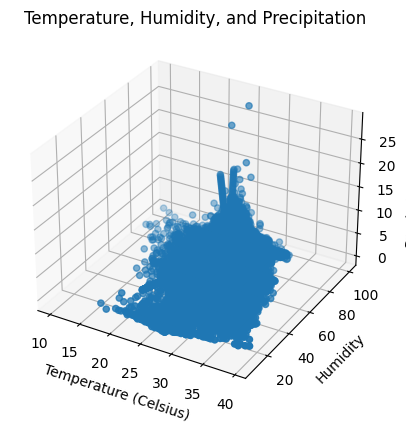

In [10]:
# Create a 3D scatter plot of temperature, humidity, and precipitation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weather_data['temp'], weather_data['hmdy'], weather_data['prcp'])
ax.set_xlabel('Temperature (Celsius)')
ax.set_ylabel('Humidity')
ax.set_zlabel('Precipitation (mm)')
plt.title('Temperature, Humidity, and Precipitation')
plt.show()


### Heatmap of average temperature by month and region:

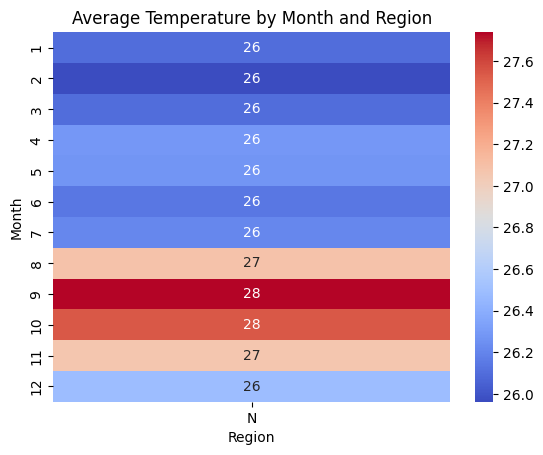

In [11]:
# Extract month from date column
weather_data['month'] = weather_data['date'].dt.month

# Group weather data by month and region and calculate mean temperature
month_region_temp = weather_data.groupby(['month', 'regi'])[
    'temp'].mean().reset_index()

# Pivot the data to create a heatmap
month_region_temp_pivot = month_region_temp.pivot(
    index='month', columns='regi', values='temp')

# Heatmap of average temperature by month and region
sns.heatmap(month_region_temp_pivot, cmap='coolwarm', annot=True)
plt.title('Average Temperature by Month and Region')
plt.xlabel('Region')
plt.ylabel('Month')
plt.show()


### Interactive map of weather stations with pop-up markers showing station name, elevation, and temperature:

In [12]:
# Create a map centered on Brazil
brazil_map = folium.Map(location=[-15.788497, -47.879873], zoom_start=5)

# Add markers for weather stations with pop-up information
for i, row in sample_df.iterrows():
    folium.Marker(location=[row['lat'], row['lon']],
                  popup=f"Station: {row['inme']}<br>Elevation: {row['elvt']}<br>Temperature: {row['temp']}",
                  icon=folium.Icon(color='red')).add_to(brazil_map)

# Display the map
brazil_map


### Interactive scatter plot of temperature vs. humidity with tooltip showing station name and region:

In [13]:
# Create an interactive scatter plot of temperature vs. humidity with tooltip information
fig = px.scatter(weather_data, x='hmdy', y='temp',
                 color='regi', hover_name='inme')

# Customize the plot
fig.update_layout(title='Temperature vs. Humidity',
                  xaxis_title='Humidity',
                  yaxis_title='Temperature (Celsius)',
                  hovermode='closest')

# Display the plot
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [14]:
# Define the interactive dashboard using Plotly Dash
app = dash.Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    html.H1("Weather Data Analysis Dashboard"),
    html.Div([
        html.H3("Heat Map of Temperature and Precipitation by Region"),
        dcc.Graph(
            id="heatmap",
            figure=px.scatter_mapbox(
                sample_df,
                lat="lat",
                lon="lon",
                color="temp",
                size="prcp",
                zoom=3,
                mapbox_style="open-street-map"
            )
        )
    ]),
    html.Div([
        html.H3("Line Chart of Historical Weather Patterns by Station"),
        dcc.Dropdown(
            id="station-selector",
            options=[{"label": s, "value": s}
                     for s in sample_df["wsnm"].unique()],
            value=sample_df["wsnm"].unique()[0]
        ),
        dcc.Graph(
            id="line-chart"
        )
    ]),
    html.Div([
        html.H3("Scatter Plot of Correlation Between Weather Variables"),
        dcc.Dropdown(
            id="variable-selector",
            options=[{"label": v, "value": v}
                     for v in sample_df.columns[8:]],
            value=sample_df.columns[8]
        ),
        dcc.Graph(
            id="scatter-plot"
        )
    ]),
    html.Div([
        html.Label("Year Slider"),
        dcc.RangeSlider(
            id="year-slider",
            min=sample_df["date"].dt.year.min(),
            max=sample_df["date"].dt.year.max(),
            value=[sample_df["date"].dt.year.min(
            ), sample_df["date"].dt.year.max()],
            marks={str(year): str(year)
                   for year in sample_df["date"].dt.year.unique()},
            step=None
        )
    ])
])

# Define the callbacks that update the plots based on user input


@app.callback(
    dash.dependencies.Output("line-chart", "figure"),
    [dash.dependencies.Input("station-selector", "value")]
)
def update_line_chart(station):
    filtered_df = sample_df[sample_df["wsnm"] == station]
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=filtered_df["date"], y=filtered_df["temp"], mode="lines", name="Temperature"))
    fig.add_trace(go.Scatter(
        x=filtered_df["date"], y=filtered_df["prcp"], mode="lines", name="Precipitation"))
    fig.update_layout(title_text=f"Historical Weather Patterns for {station}")
    return fig


# Start the Dash app
if __name__ == "__main__":
    app.run_server(debug=True, use_reloader=False)


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: on


In [ ]:
# # Define the Dash app
# app = dash.Dash(__name__)

# # Define the layout of the app
# app.layout = html.Div([
#     html.H1('Weather Data Dashboard'),
#     dcc.Graph(id='scatter-plot'),
#     html.Label('Select a region:'),
#     dcc.Dropdown(
#         id='region-dropdown',
#         options=[{'label': r, 'value': r}
#                  for r in weather_data['wsnm'].unique()],
#         value=weather_data['wsnm'].unique()[0]
#     ),
#     html.Label('Select a variable to plot:'),
#     dcc.RadioItems(
#         id='variable-radio',
#         options=[
#             {'label': 'Temperature', 'value': 'temperature'},
#             {'label': 'Humidity', 'value': 'humidity'},
#             {'label': 'Precipitation', 'value': 'precipitation'}
#         ],
#         value='temp'
#     ),
#     html.Br(),
#     html.Label('Select a date range:'),
#     dcc.RangeSlider(
#         id='date-slider',
#         min=weather_data['date'].min().year,
#         max=weather_data['date'].max().year,
#         step=None,
#         marks={str(year): str(year)
#                for year in weather_data['date'].dt.year.unique()},
#         value=[weather_data['date'].min().year, weather_data['date'].max().year]
#     )
# ])


# # Define the callback functions for the app
# @app.callback(
#     Output('scatter-plot', 'figure'),
#     [Input('region-dropdown', 'value'),
#      Input('variable-radio', 'value'),
#      Input('date-slider', 'value')])

# def update_scatter_plot(wsnm, date_range):
#     # Filter the data based on the user inputs
#     filtered_data = weather_data[(weather_data['wsnm'] == wsnm) &
#                                  (weather_data['date'].dt.year >= date_range[0]) &
#                                  (weather_data['date'].dt.year <= date_range[1])]
#     # Create the scatter plot
#     fig = px.scatter(filtered_data, x='lat',
#                      y='lon')
#     return fig


# # Run the app
# if __name__ == '__main__':
#     app.run_server(debug=True, use_reloader=False)


In [ ]:
# # Define the layout of the Dash app
# app = dash.Dash(__name__)

# app.layout = html.Div([
#     html.H1("Weather Data Visualization"),
#     dcc.Dropdown(
#         id="field-dropdown",
#         options=[{"label": col, "value": col} for col in weather_data.columns],
#         value="temperature"
#     ),
#     dcc.Graph(id="field-graph")
# ])

# # Define the callback function that updates the graph based on the selected field
# @app.callback(
#     dash.dependencies.Output("field-graph", "figure"),
#     [dash.dependencies.Input("field-dropdown", "value")]
# )
# def update_graph(field):
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(
#         x=weather_data["date"],
#         y=weather_data[field],
#         mode="lines",
#         name=field
#     ))
#     fig.update_layout(
#         title=field.capitalize() + " over Time",
#         xaxis_title="Date",
#         yaxis_title=field.capitalize(),
#         template="plotly_white"
#     )
#     return fig


# # Start the Dash app
# if __name__ == "__main__":
#     app.run_server(debug=True, use_reloader=False)
